### Run this script to plot with latex on a linux machine or Google Colab

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
!pip install -r requirements.txt

# Main code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from collections import defaultdict

from evaluation import eval, eval_multi, logger, MODE_ADVERSARY, MODE_ADVERSARY_RANDOMIZE, MODE_RANDOM, MODE_ADV_TASK_DIVERSITY
import matplotlib as mpl

mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")
%load_ext autoreload
%autoreload 2

In [25]:
T = 2000  # Timesteps/horizon
n_task = 6000
alpha_set = [1.0]  # Bonus for UCB
v_set = [1.0]  # Bonus for TS
alpha_PHE_set = [1.0]  # Bonus for PHE
tau_1_PEGE_set = [T // 2]  # EXR length for PEGE
is_multi = True
input_dict = {
    "d": 10,  # n_dims
    "unit_ball_action": True,
    # "n_gen_context":20, #if not unit ball action set, how many action sampled from the action set
    "T": T,  # Timesteps/horizon
    "n_sim": 5,  # Number of Simulations
    "rho": 0.5,
    "noise_std": 1,
    "seed": None,  # TODO: bug here, must set to None
    "output": True,
    "params_set": alpha_set,
    "m": 3,  # n_dims latent
    "n_task": n_task,
    "mode": MODE_ADV_TASK_DIVERSITY,
    "adv_exr_const": 0.1,  # scaling factor for adversary task generation
    "adv_exr_task": None,  # specific tasks to reveal a new dimension
    "PMA_exr_const": 1.5,  # scaling factor for exploration probability
    "PMA_lr_const": 1,  # scaling factor for the learning rate
    "PMA_n_expert": 100000,  # Expert set size for PMA
    "PMA_tau1_const": 1,  # scaling factor for PEGE's EXR length in the EXR phase
    "PMA_tau2_const": 1,  # scaling factor for PEGE's EXR length in the EXT phase
    "PMA_alpha_const": 1,  # scaling factor for PMA's alpha threshold
    "p_decay_rate": 0,  # decay rate for EXR prob. May be useful for Task Diversity setting
    "PMA_stop_exr": n_task,  # Stop EXR after PMA_stop_exr step
    "PMA_no_oracle": False,
    "SeqRepL_exr_const": 1.5,
    "SeqRepL_tau1_const": 1,
    "SeqRepL_tau2_const": 1,
    "SeqRepL_stop_exr": n_task,  # Stop EXR after PMA_stop_exr step
    "fixed_params": [0.1, 400, 50],  # fixed params for [p, tau1, tau2]
    "SeqRepL_exr_list": None,
    # BRESS parameters
    "OnlinePCA_exr_const": 1.5,
    "OnlinePCA_tau1_const": 1,
    "OnlinePCA_tau2_const": 1,
    "OnlinePCA_stop_exr": n_task,
}


def get_SeqRepL_exr_list(n_task):
    SeqRepL_exr_list = []
    i = 0
    while i**2 <= n_task:
        SeqRepL_exr_list.append(i**2)
        i += 1
    return SeqRepL_exr_list


def check_params():
    m = input_dict["m"]
    d = input_dict["d"]
    assert m <= d, "m >= d"
    if T < d**2:
        logger.info(f"Warning: T < d**2")
    if n_task < np.sqrt(T):
        logger.info(f"Warning: n_task < np.sqrt(T)")
    if input_dict["adv_exr_task"] is not None:
        assert (
            max(input_dict["adv_exr_task"]) < input_dict["n_task"]
        ), f"max exr task ({max(input_dict['adv_exr_task'])}) is larger than n_task ({input_dict['n_task']})"
        assert (
            len(input_dict["adv_exr_task"]) == input_dict["m"]
        ), f"exr list (len={len(input_dict['adv_exr_task'])}) is incorrect (!= m ({input_dict['m']}))"


def load_dict(name):
    input_dict = np.load(name, allow_pickle="TRUE").item()
    input_dict = defaultdict(int, input_dict)
    mean_PEGE2 = input_dict["mean_PEGE2"]
    std_PEGE2 = input_dict["std_PEGE2"]
    mean_PEGE_oracle2 = input_dict["mean_PEGE_oracle2"]
    std_PEGE_oracle2 = input_dict["std_PEGE_oracle2"]
    mean_PMA2 = input_dict["mean_PMA2"]
    std_PMA2 = input_dict["std_PMA2"]
    mean_PMA_no_oracle2 = input_dict["mean_PMA_no_oracle2"]
    std_PMA_no_oracle2 = input_dict["std_PMA_no_oracle2"]
    mean_SeqRepL2 = input_dict["mean_SeqRepL2"]
    std_SeqRepL2 = input_dict["std_SeqRepL2"]
    return (
        mean_PEGE2,
        std_PEGE2,
        mean_PEGE_oracle2,
        std_PEGE_oracle2,
        mean_PMA2,
        std_PMA2,
        mean_PMA_no_oracle2,
        std_PMA_no_oracle2,
        mean_SeqRepL2,
        std_SeqRepL2,
    )


# Update fixed params for Task Diversity
input_dict["fixed_params"] = [0.15, 1000, 300]
# Run experiments (set run_experiments = True to run, False to load from cache)
run_experiments = True

## With Task Diversity

In [26]:
if run_experiments:
    check_params()
    
    input_dict["name"] = "PEGE"
    input_dict["params_set"] = [190, 210]  # tau_1
    best_PEGE = eval_multi(input_dict)
    
    input_dict["name"] = "PEGE_oracle"
    input_dict["params_set"] = [45, 55]  # tau_2
    best_PEGE_oracle = eval_multi(input_dict)
    
    input_dict["name"] = "PMA"
    input_dict["params_set"] = [None]  # Placeholder
    input_dict["PMA_no_oracle"] = False
    best_PMA = eval_multi(input_dict)
    
    input_dict["name"] = "PMA"
    input_dict["PMA_no_oracle"] = True
    best_PMA_no_oracle = eval_multi(input_dict)
    
    input_dict["name"] = "SeqRepL"
    best_SeqRepL = eval_multi(input_dict)
    
    input_dict["name"] = "BRESS"
    input_dict["params_set"] = [None]
    best_BRESS = eval_multi(input_dict)


PEGE Simulation 1, d=10


100%|██████████| 6000/6000 [02:39<00:00, 37.60it/s]


PEGE Simulation 2, d=10


100%|██████████| 6000/6000 [02:39<00:00, 37.65it/s]


PEGE Simulation 3, d=10


100%|██████████| 6000/6000 [02:37<00:00, 38.08it/s]


PEGE Simulation 4, d=10


100%|██████████| 6000/6000 [02:38<00:00, 37.85it/s]


PEGE Simulation 5, d=10


100%|██████████| 6000/6000 [02:39<00:00, 37.63it/s]


PEGE Simulation 1, d=10


100%|██████████| 6000/6000 [02:38<00:00, 37.74it/s]


PEGE Simulation 2, d=10


100%|██████████| 6000/6000 [02:37<00:00, 38.17it/s]


PEGE Simulation 3, d=10


100%|██████████| 6000/6000 [02:36<00:00, 38.29it/s]


PEGE Simulation 4, d=10


100%|██████████| 6000/6000 [02:37<00:00, 38.16it/s]


PEGE Simulation 5, d=10


100%|██████████| 6000/6000 [02:37<00:00, 38.17it/s]


PEGE_oracle Simulation 1, d=10


100%|██████████| 6000/6000 [01:44<00:00, 57.29it/s]


PEGE_oracle Simulation 2, d=10


100%|██████████| 6000/6000 [01:44<00:00, 57.22it/s]


PEGE_oracle Simulation 3, d=10


100%|██████████| 6000/6000 [01:45<00:00, 57.11it/s]


PEGE_oracle Simulation 4, d=10


100%|██████████| 6000/6000 [01:45<00:00, 56.88it/s]


PEGE_oracle Simulation 5, d=10


100%|██████████| 6000/6000 [01:45<00:00, 57.00it/s]


PEGE_oracle Simulation 1, d=10


100%|██████████| 6000/6000 [01:46<00:00, 56.58it/s]


PEGE_oracle Simulation 2, d=10


100%|██████████| 6000/6000 [01:45<00:00, 56.64it/s]


PEGE_oracle Simulation 3, d=10


100%|██████████| 6000/6000 [01:46<00:00, 56.56it/s]


PEGE_oracle Simulation 4, d=10


100%|██████████| 6000/6000 [01:51<00:00, 53.97it/s]


PEGE_oracle Simulation 5, d=10


100%|██████████| 6000/6000 [01:52<00:00, 53.49it/s]


PMA Simulation 1, d=10


100%|██████████| 6000/6000 [07:33<00:00, 13.23it/s]


PMA Simulation 2, d=10


100%|██████████| 6000/6000 [07:48<00:00, 12.80it/s]


PMA Simulation 3, d=10


100%|██████████| 6000/6000 [07:39<00:00, 13.05it/s]


PMA Simulation 4, d=10


100%|██████████| 6000/6000 [07:34<00:00, 13.21it/s]


PMA Simulation 5, d=10


100%|██████████| 6000/6000 [07:27<00:00, 13.42it/s]


PMA Simulation 1, d=10


100%|██████████| 6000/6000 [07:45<00:00, 12.89it/s]


PMA Simulation 2, d=10


100%|██████████| 6000/6000 [07:35<00:00, 13.18it/s]


PMA Simulation 3, d=10


100%|██████████| 6000/6000 [07:41<00:00, 13.01it/s]


PMA Simulation 4, d=10


100%|██████████| 6000/6000 [07:34<00:00, 13.20it/s]


PMA Simulation 5, d=10


100%|██████████| 6000/6000 [07:48<00:00, 12.80it/s]


SeqRepL Simulation 1, d=10


100%|██████████| 6000/6000 [02:51<00:00, 35.04it/s]


SeqRepL Simulation 2, d=10


100%|██████████| 6000/6000 [02:52<00:00, 34.77it/s]


SeqRepL Simulation 3, d=10


100%|██████████| 6000/6000 [02:53<00:00, 34.49it/s]


SeqRepL Simulation 4, d=10


100%|██████████| 6000/6000 [02:47<00:00, 35.84it/s]


SeqRepL Simulation 5, d=10


100%|██████████| 6000/6000 [02:46<00:00, 36.06it/s]


BRESS Simulation 1, d=10


  0%|          | 0/6000 [00:00<?, ?it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.987671 != 1, normalizing
  warnings.warn(
  0%|          | 1/6000 [00:00<14:02,  7.12it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988239 != 1, normalizing
  warnings.warn(
  0%|          | 6/6000 [00:00<04:30, 22.14it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.987926 != 1, normalizing
  warnings.warn(
  0%|          | 14/6000 [00:00<03:06, 32.10it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.987630 != 1, normalizing
  warnings.warn(
/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.989512 != 1, normalizing
  warnings.warn(
  0%|          

BRESS Simulation 2, d=10


  0%|          | 1/6000 [00:00<13:01,  7.67it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.987644 != 1, normalizing
  warnings.warn(
  0%|          | 4/6000 [00:00<05:33, 17.95it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988461 != 1, normalizing
  warnings.warn(
  0%|          | 7/6000 [00:00<04:33, 21.92it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.987265 != 1, normalizing
  warnings.warn(
  0%|          | 12/6000 [00:00<03:40, 27.20it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.989145 != 1, normalizing
  warnings.warn(
  0%|          | 15/6000 [00:00<03:38, 27.36it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.

BRESS Simulation 3, d=10


  0%|          | 6/6000 [00:00<03:40, 27.18it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.987985 != 1, normalizing
  warnings.warn(
  0%|          | 29/6000 [00:00<02:17, 43.43it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.987819 != 1, normalizing
  warnings.warn(
  1%|          | 39/6000 [00:01<02:22, 41.71it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988481 != 1, normalizing
  warnings.warn(
/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.987599 != 1, normalizing
  warnings.warn(
  1%|          | 49/6000 [00:01<02:37, 37.71it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.990014 != 1, normalizing
  warnings.warn(
  1%|

BRESS Simulation 4, d=10


  0%|          | 21/6000 [00:00<02:19, 42.77it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988264 != 1, normalizing
  warnings.warn(
/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988792 != 1, normalizing
  warnings.warn(
  1%|          | 36/6000 [00:00<02:25, 41.05it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988188 != 1, normalizing
  warnings.warn(
  1%|          | 41/6000 [00:01<02:35, 38.30it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988804 != 1, normalizing
  warnings.warn(
  1%|          | 51/6000 [00:01<02:32, 39.12it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.989812 != 1, normalizing
  warnings.warn(
  1%

BRESS Simulation 5, d=10


  0%|          | 1/6000 [00:00<13:23,  7.46it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988681 != 1, normalizing
  warnings.warn(
  0%|          | 4/6000 [00:00<05:36, 17.81it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.987664 != 1, normalizing
  warnings.warn(
  0%|          | 7/6000 [00:00<04:30, 22.15it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.989570 != 1, normalizing
  warnings.warn(
  0%|          | 12/6000 [00:00<03:41, 27.08it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988462 != 1, normalizing
  warnings.warn(
/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988966 != 1, normalizing
  warnings.warn(
  0%|  

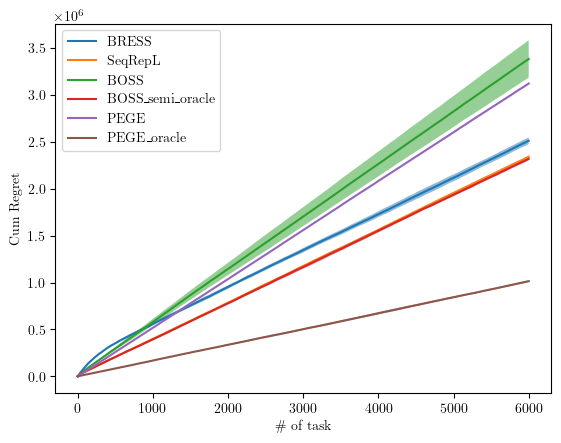

In [ ]:
if run_experiments:
    mean_PEGE = np.mean(best_PEGE["regrets"], axis=0)
    std_PEGE = np.std(best_PEGE["regrets"], axis=0)
    mean_PEGE_oracle = np.mean(best_PEGE_oracle["regrets"], axis=0)
    std_PEGE_oracle = np.std(best_PEGE_oracle["regrets"], axis=0)
    mean_PMA = np.mean(best_PMA["regrets"], axis=0)
    std_PMA = np.std(best_PMA["regrets"], axis=0)
    mean_PMA_no_oracle = np.mean(best_PMA_no_oracle["regrets"], axis=0)
    std_PMA_no_oracle = np.std(best_PMA_no_oracle["regrets"], axis=0)
    mean_SeqRepL = np.mean(best_SeqRepL["regrets"], axis=0)
    std_SeqRepL = np.std(best_SeqRepL["regrets"], axis=0)
    mean_BRESS = np.mean(best_BRESS["regrets"], axis=0)
    std_BRESS = np.std(best_BRESS["regrets"], axis=0)
else:
    (
        mean_PEGE,
        std_PEGE,
        mean_PEGE_oracle,
        std_PEGE_oracle,
        mean_PMA,
        std_PMA,
        mean_PMA_no_oracle,
        std_PMA_no_oracle,
        mean_SeqRepL,
        std_SeqRepL,
    ) = load_dict("cache_data/TaskDiv_RegExp.npy")
    mean_BRESS, std_BRESS = None, None  # No cached data for BRESS

X = np.arange(1, n_task + 1)
if mean_BRESS is not None:
    plt.plot(X, mean_BRESS, "-", label="BRESS")
    plt.fill_between(X, mean_BRESS - std_BRESS, mean_BRESS + std_BRESS, alpha=0.5)
plt.plot(X, mean_SeqRepL, "-", label="SeqRepL")
plt.fill_between(X, mean_SeqRepL - std_SeqRepL, mean_SeqRepL + std_SeqRepL, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle, "-", label="BOSS")
plt.fill_between(
    X,
    mean_PMA_no_oracle - std_PMA_no_oracle,
    mean_PMA_no_oracle + std_PMA_no_oracle,
    alpha=0.5,
)
plt.plot(X, mean_PMA, "-", label=r"BOSS\_semi\_oracle")
plt.fill_between(X, mean_PMA - std_PMA, mean_PMA + std_PMA, alpha=0.5)
plt.plot(X, mean_PEGE, "-", label="PEGE")
plt.fill_between(X, mean_PEGE - std_PEGE, mean_PEGE + std_PEGE, alpha=0.5)
plt.plot(X, mean_PEGE_oracle, "-", label=r"PEGE\_oracle")
plt.fill_between(
    X, mean_PEGE_oracle - std_PEGE_oracle, mean_PEGE_oracle + std_PEGE_oracle, alpha=0.5
)
plt.xlabel(r"$\#$ of task")
plt.ylabel("Cum Regret")
plt.legend()
plt.show()
plt.close()
output_dict = {
    "mean_PEGE2":mean_PEGE,
    "std_PEGE2":std_PEGE,
    "mean_PEGE_oracle2":mean_PEGE_oracle,
    "std_PEGE_oracle2":std_PEGE_oracle,
    "mean_PMA2":mean_PMA,
    "std_PMA2":std_PMA,
    "mean_PMA_no_oracle2":mean_PMA_no_oracle,
    "std_PMA_no_oracle2":std_PMA_no_oracle,
    "mean_SeqRepL2":mean_SeqRepL,
    "std_SeqRepL2":std_SeqRepL,
}
np.save('cache_data/TaskDiv_RegExp.npy', output_dict)

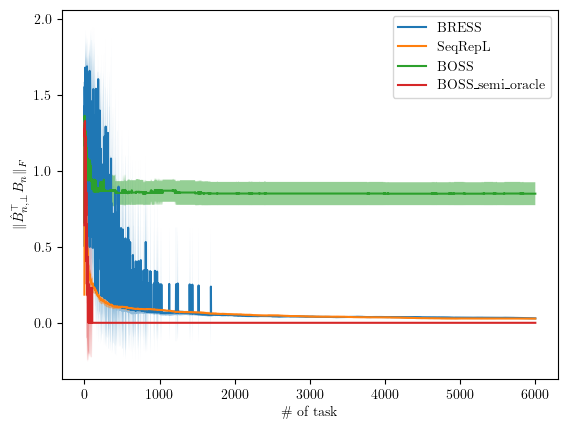

In [ ]:
if run_experiments:
    mean_PMA = np.mean(best_PMA["B_hat_err"], axis=0)
    std_PMA = np.std(best_PMA["B_hat_err"], axis=0)
    mean_SeqRepL = np.mean(best_SeqRepL["B_hat_err"], axis=0)
    std_SeqRepL = np.std(best_SeqRepL["B_hat_err"], axis=0)
    mean_PMA_no_oracle = np.mean(best_PMA_no_oracle["B_hat_err"], axis=0)
    std_PMA_no_oracle = np.std(best_PMA_no_oracle["B_hat_err"], axis=0)
    mean_BRESS = np.mean(best_BRESS["B_hat_err"], axis=0)
    std_BRESS = np.std(best_BRESS["B_hat_err"], axis=0)
else:
    (
        mean_PEGE,
        std_PEGE,
        mean_PEGE_oracle,
        std_PEGE_oracle,
        mean_PMA,
        std_PMA,
        mean_PMA_no_oracle,
        std_PMA_no_oracle,
        mean_SeqRepL,
        std_SeqRepL,
    ) = load_dict("cache_data/TaskDiv_B.npy")
    mean_BRESS, std_BRESS = None, None

if mean_BRESS is not None:
    plt.plot(X, mean_BRESS, "-", label="BRESS")
    plt.fill_between(X, mean_BRESS - std_BRESS, mean_BRESS + std_BRESS, alpha=0.5)
plt.plot(X, mean_SeqRepL, "-", label="SeqRepL")
plt.fill_between(X, mean_SeqRepL - std_SeqRepL, mean_SeqRepL + std_SeqRepL, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle, "-", label="BOSS")
plt.fill_between(
    X,
    mean_PMA_no_oracle - std_PMA_no_oracle,
    mean_PMA_no_oracle + std_PMA_no_oracle,
    alpha=0.5,
)
plt.plot(X, mean_PMA, "-", label=r"BOSS\_semi\_oracle")
plt.fill_between(X, mean_PMA - std_PMA, mean_PMA + std_PMA, alpha=0.5)
plt.xlabel(r"$\#$ of task")
plt.ylabel(r"$\|\hat{B}_{n, \perp}^{\top} B_n\|_F$")
plt.legend()
plt.show()
plt.close()
output_dict = {
    "mean_PMA2":mean_PMA,
    "std_PMA2":std_PMA,
    "mean_PMA_no_oracle2":mean_PMA_no_oracle,
    "std_PMA_no_oracle2":std_PMA_no_oracle,
    "mean_SeqRepL2":mean_SeqRepL,
    "std_SeqRepL2":std_SeqRepL,
}
np.save('cache_data/TaskDiv_B.npy', output_dict)

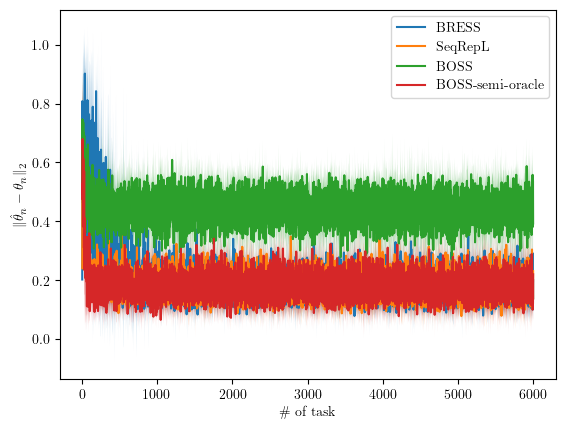

In [ ]:
if run_experiments:
    mean_PMA = np.mean(best_PMA["theta_hat_err"], axis=0)
    std_PMA = np.std(best_PMA["theta_hat_err"], axis=0)
    mean_SeqRepL = np.mean(best_SeqRepL["theta_hat_err"], axis=0)
    std_SeqRepL = np.std(best_SeqRepL["theta_hat_err"], axis=0)
    mean_PMA_no_oracle = np.mean(best_PMA_no_oracle["theta_hat_err"], axis=0)
    std_PMA_no_oracle = np.std(best_PMA_no_oracle["theta_hat_err"], axis=0)
    mean_BRESS = np.mean(best_BRESS["theta_hat_err"], axis=0)
    std_BRESS = np.std(best_BRESS["theta_hat_err"], axis=0)
else:
    (
        mean_PEGE,
        std_PEGE,
        mean_PEGE_oracle,
        std_PEGE_oracle,
        mean_PMA,
        std_PMA,
        mean_PMA_no_oracle,
        std_PMA_no_oracle,
        mean_SeqRepL,
        std_SeqRepL,
    ) = load_dict("cache_data/TaskDiv_theta.npy")
    mean_BRESS, std_BRESS = None, None

X = np.arange(1, n_task + 1)
if mean_BRESS is not None:
    plt.plot(X, mean_BRESS, "-", label="BRESS")
    plt.fill_between(X, mean_BRESS - std_BRESS, mean_BRESS + std_BRESS, alpha=0.5)
plt.plot(X, mean_SeqRepL, "-", label="SeqRepL")
plt.fill_between(X, mean_SeqRepL - std_SeqRepL, mean_SeqRepL + std_SeqRepL, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle, "-", label="BOSS")
plt.fill_between(
    X,
    mean_PMA_no_oracle - std_PMA_no_oracle,
    mean_PMA_no_oracle + std_PMA_no_oracle,
    alpha=0.5,
)
plt.plot(X, mean_PMA, "-", label=r"BOSS-semi-oracle")
plt.fill_between(X, mean_PMA - std_PMA, mean_PMA + std_PMA, alpha=0.5)
plt.xlabel(r"$\#$ of task")
plt.ylabel(r"$\|\hat{\theta}_n - \theta_n\|_2$")
plt.legend()
plt.show()
plt.close()
output_dict = {
    "mean_PMA2":mean_PMA,
    "std_PMA2":std_PMA,
    "mean_PMA_no_oracle2":mean_PMA_no_oracle,
    "std_PMA_no_oracle2":std_PMA_no_oracle,
    "mean_SeqRepL2":mean_SeqRepL,
    "std_SeqRepL2":std_SeqRepL,
}
np.save('cache_data/TaskDiv_theta.npy', output_dict)

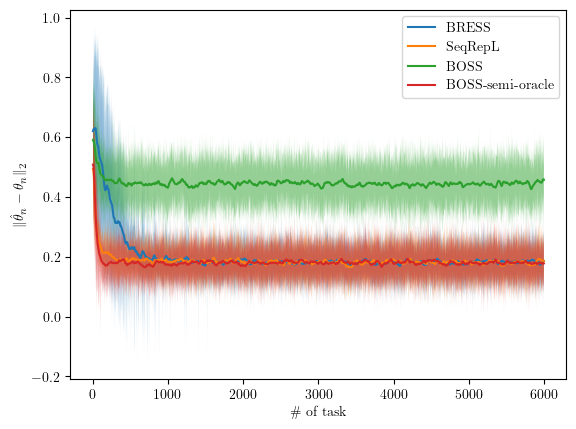

In [30]:
rbf = Rbf(X, mean_PMA_no_oracle, function="multiquadric", smooth=500)
y_PMA_no_oracle_rbf = rbf(X)
rbf = Rbf(X, mean_PMA, function="multiquadric", smooth=500)
y_PMA_rbf = rbf(X)
rbf = Rbf(X, mean_SeqRepL, function="multiquadric", smooth=500)
y_SeqRepL_rbf = rbf(X)
if mean_BRESS is not None:
    rbf = Rbf(X, mean_BRESS, function="multiquadric", smooth=500)
    y_BRESS_rbf = rbf(X)

if mean_BRESS is not None:
    plt.plot(X, y_BRESS_rbf, "-", label="BRESS")
    plt.fill_between(X, y_BRESS_rbf - std_BRESS, y_BRESS_rbf + std_BRESS, alpha=0.5)
plt.plot(X, y_SeqRepL_rbf, "-", label="SeqRepL")
plt.fill_between(X, y_SeqRepL_rbf - std_SeqRepL, y_SeqRepL_rbf + std_SeqRepL, alpha=0.5)
plt.plot(X, y_PMA_no_oracle_rbf, "-", label="BOSS")
plt.fill_between(
    X,
    y_PMA_no_oracle_rbf - std_PMA_no_oracle,
    y_PMA_no_oracle_rbf + std_PMA_no_oracle,
    alpha=0.5,
)
plt.plot(X, y_PMA_rbf, "-", label="BOSS-semi-oracle")
plt.fill_between(X, y_PMA_rbf - std_PMA, y_PMA_rbf + std_PMA, alpha=0.5)
plt.xlabel(r"$\#$ of task")
plt.ylabel(r"$\|\hat{\theta}_n - \theta_n\|_2$")

plt.legend()
plt.show()

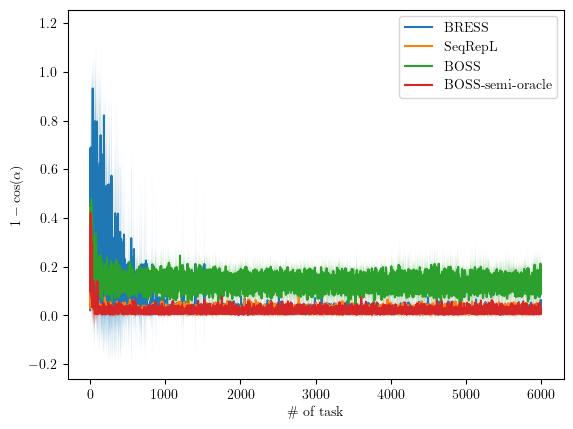

In [ ]:
if run_experiments:
    mean_PMA = np.mean(best_PMA["angle_err"], axis=0)
    std_PMA = np.std(best_PMA["angle_err"], axis=0)
    mean_SeqRepL = np.mean(best_SeqRepL["angle_err"], axis=0)
    std_SeqRepL = np.std(best_SeqRepL["angle_err"], axis=0)
    mean_PMA_no_oracle = np.mean(best_PMA_no_oracle["angle_err"], axis=0)
    std_PMA_no_oracle = np.std(best_PMA_no_oracle["angle_err"], axis=0)
    mean_BRESS = np.mean(best_BRESS["angle_err"], axis=0)
    std_BRESS = np.std(best_BRESS["angle_err"], axis=0)
else:
    (
        mean_PEGE,
        std_PEGE,
        mean_PEGE_oracle,
        std_PEGE_oracle,
        mean_PMA,
        std_PMA,
        mean_PMA_no_oracle,
        std_PMA_no_oracle,
        mean_SeqRepL,
        std_SeqRepL,
    ) = load_dict("cache_data/TaskDiv_angle.npy")
    mean_BRESS, std_BRESS = None, None

X = np.arange(1, n_task + 1)
if mean_BRESS is not None:
    plt.plot(X, mean_BRESS, "-", label="BRESS")
    plt.fill_between(X, mean_BRESS - std_BRESS, mean_BRESS + std_BRESS, alpha=0.5)
plt.plot(X, mean_SeqRepL, "-", label="SeqRepL")
plt.fill_between(X, mean_SeqRepL - std_SeqRepL, mean_SeqRepL + std_SeqRepL, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle, "-", label="BOSS")
plt.fill_between(
    X,
    mean_PMA_no_oracle - std_PMA_no_oracle,
    mean_PMA_no_oracle + std_PMA_no_oracle,
    alpha=0.5,
)
plt.plot(X, mean_PMA, "-", label="BOSS-semi-oracle")
plt.fill_between(X, mean_PMA - std_PMA, mean_PMA + std_PMA, alpha=0.5)
plt.xlabel(r"$\#$ of task")
plt.ylabel(r"$1-\cos(\alpha)$")
plt.legend()
plt.show()
plt.close()
output_dict = {
    "mean_PMA2":mean_PMA,
    "std_PMA2":std_PMA,
    "mean_PMA_no_oracle2":mean_PMA_no_oracle,
    "std_PMA_no_oracle2":std_PMA_no_oracle,
    "mean_SeqRepL2":mean_SeqRepL,
    "std_SeqRepL2":std_SeqRepL,
}
np.save('cache_data/TaskDiv_angle.npy', output_dict)

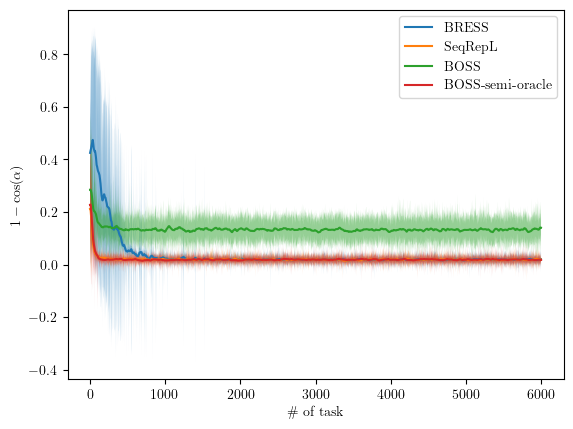

In [32]:
rbf = Rbf(X, mean_PMA_no_oracle, function="multiquadric", smooth=500)
y_PMA_no_oracle_rbf = rbf(X)
rbf = Rbf(X, mean_PMA, function="multiquadric", smooth=500)
y_PMA_rbf = rbf(X)
rbf = Rbf(X, mean_SeqRepL, function="multiquadric", smooth=500)
y_SeqRepL_rbf = rbf(X)
if mean_BRESS is not None:
    rbf = Rbf(X, mean_BRESS, function="multiquadric", smooth=500)
    y_BRESS_rbf = rbf(X)

if mean_BRESS is not None:
    plt.plot(X, y_BRESS_rbf, "-", label="BRESS")
    plt.fill_between(X, y_BRESS_rbf - std_BRESS, y_BRESS_rbf + std_BRESS, alpha=0.5)
plt.plot(X, y_SeqRepL_rbf, "-", label="SeqRepL")
plt.fill_between(X, y_SeqRepL_rbf - std_SeqRepL, y_SeqRepL_rbf + std_SeqRepL, alpha=0.5)
plt.plot(X, y_PMA_no_oracle_rbf, "-", label="BOSS")
plt.fill_between(
    X,
    y_PMA_no_oracle_rbf - std_PMA_no_oracle,
    y_PMA_no_oracle_rbf + std_PMA_no_oracle,
    alpha=0.5,
)
plt.plot(X, y_PMA_rbf, "-", label="BOSS-semi-oracle")
plt.fill_between(X, y_PMA_rbf - std_PMA, y_PMA_rbf + std_PMA, alpha=0.5)
plt.xlabel(r"$\#$ of task")
plt.ylabel(r"$1-\cos(\alpha)$")

plt.legend()
plt.show()

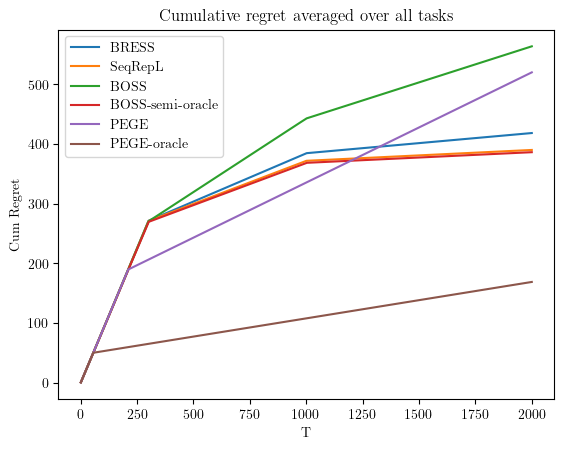

In [ ]:
if run_experiments:
    mean_PEGE_in_T = np.mean(best_PEGE["regrets_all"], axis=(0, -1))
    std_PEGE_in_T = np.std(best_PEGE["regrets_all"], axis=(0, -1))
    mean_PEGE_oracle_in_T = np.mean(best_PEGE_oracle["regrets_all"], axis=(0, -1))
    std_PEGE_oracle_in_T = np.std(best_PEGE_oracle["regrets_all"], axis=(0, -1))
    mean_PMA_in_T = np.mean(best_PMA["regrets_all"], axis=(0, -1))
    std_PMA_in_T = np.std(best_PMA["regrets_all"], axis=(0, -1))
    mean_PMA_no_oracle_in_T = np.mean(best_PMA_no_oracle["regrets_all"], axis=(0, -1))
    std_PMA_no_oracle_in_T = np.std(best_PMA_no_oracle["regrets_all"], axis=(0, -1))
    mean_SeqRepL_in_T = np.mean(best_SeqRepL["regrets_all"], axis=(0, -1))
    std_SeqRepL_in_T = np.std(best_SeqRepL["regrets_all"], axis=(0, -1))
    mean_BRESS_in_T = np.mean(best_BRESS["regrets_all"], axis=(0, -1))
    std_BRESS_in_T = np.std(best_BRESS["regrets_all"], axis=(0, -1))
else:
    (
        mean_PEGE_in_T,
        std_PEGE_in_T,
        mean_PEGE_oracle_in_T,
        std_PEGE_oracle_in_T,
        mean_PMA_in_T,
        std_PMA_in_T,
        mean_PMA_no_oracle_in_T,
        std_PMA_no_oracle_in_T,
        mean_SeqRepL_in_T,
        std_SeqRepL_in_T,
    ) = load_dict("cache_data/TaskDiv_T.npy")
    mean_BRESS_in_T = None


X = np.arange(1, T + 1)
if mean_BRESS_in_T is not None:
    plt.plot(X, mean_BRESS_in_T, "-", label="BRESS")
plt.plot(X, mean_SeqRepL_in_T, "-", label="SeqRepL")
plt.plot(X, mean_PMA_no_oracle_in_T, "-", label="BOSS")
plt.plot(X, mean_PMA_in_T, "-", label="BOSS-semi-oracle")
plt.plot(X, mean_PEGE_in_T, "-", label="PEGE")
plt.plot(X, mean_PEGE_oracle_in_T, "-", label="PEGE-oracle")
plt.xlabel("T")
plt.ylabel("Cum Regret")
plt.legend()
plt.title(f"Cumulative regret averaged over all tasks")
plt.show()
plt.close()
output_dict = {
    "mean_PEGE2":mean_PEGE_in_T,
    "std_PEGE2":std_PEGE_in_T,
    "mean_PEGE_oracle2":mean_PEGE_oracle_in_T,
    "std_PEGE_oracle2":std_PEGE_oracle_in_T,
    "mean_PMA2":mean_PMA_in_T,
    "std_PMA2":std_PMA_in_T,
    "mean_PMA_no_oracle2":mean_PMA_no_oracle_in_T,
    "std_PMA_no_oracle2":std_PMA_no_oracle_in_T,
    "mean_SeqRepL2":mean_SeqRepL_in_T,
    "std_SeqRepL2":std_SeqRepL_in_T,
}
np.save('cache_data/TaskDiv_T.npy', output_dict)

## Without Task Diversity

In [3]:
# Setup Without Task Diversity mode
input_dict["mode"] = MODE_ADVERSARY
input_dict["n_sim"] = 5
input_dict["adv_exr_task"] = [0, 500, 1000]
SeqRepL_exr_list = get_SeqRepL_exr_list(input_dict["n_task"])
input_dict["SeqRepL_exr_list"] = SeqRepL_exr_list
input_dict["fixed_params"] = [
    5 * len(SeqRepL_exr_list) / input_dict["n_task"],
    1000,
    300,
]

if run_experiments:
    check_params()
    
    input_dict["name"] = "PEGE"
    input_dict["params_set"] = [190, 210]  # tau_1
    best_PEGE2 = eval_multi(input_dict)
    
    input_dict["name"] = "PEGE_oracle"
    input_dict["params_set"] = [45, 55]  # tau_1
    best_PEGE_oracle2 = eval_multi(input_dict)
    
    input_dict["name"] = "PMA"
    input_dict["PMA_no_oracle"] = False
    best_PMA2 = eval_multi(input_dict)
    
    input_dict["name"] = "PMA"
    input_dict["PMA_no_oracle"] = True
    best_PMA_no_oracle2 = eval_multi(input_dict)
    
    input_dict["name"] = "SeqRepL"
    best_SeqRepL2 = eval_multi(input_dict)
    
    input_dict["name"] = "BRESS"
    input_dict["params_set"] = [None]
    best_BRESS2 = eval_multi(input_dict)


PEGE Simulation 1, d=10


100%|██████████| 6000/6000 [02:36<00:00, 38.22it/s]


PEGE Simulation 2, d=10


100%|██████████| 6000/6000 [02:37<00:00, 38.16it/s]


PEGE Simulation 3, d=10


100%|██████████| 6000/6000 [12:37<00:00,  7.92it/s]   


PEGE Simulation 4, d=10


100%|██████████| 6000/6000 [1:43:28<00:00,  1.03s/it]   


PEGE Simulation 5, d=10


100%|██████████| 6000/6000 [22:54<00:00,  4.37it/s]  


PEGE Simulation 1, d=10


100%|██████████| 6000/6000 [02:42<00:00, 36.96it/s]


PEGE Simulation 2, d=10


100%|██████████| 6000/6000 [02:41<00:00, 37.05it/s]


PEGE Simulation 3, d=10


100%|██████████| 6000/6000 [02:42<00:00, 37.02it/s]


PEGE Simulation 4, d=10


100%|██████████| 6000/6000 [02:41<00:00, 37.14it/s]


PEGE Simulation 5, d=10


100%|██████████| 6000/6000 [02:35<00:00, 38.53it/s]


PEGE_oracle Simulation 1, d=10


100%|██████████| 6000/6000 [01:44<00:00, 57.35it/s]


PEGE_oracle Simulation 2, d=10


100%|██████████| 6000/6000 [01:44<00:00, 57.37it/s]


PEGE_oracle Simulation 3, d=10


100%|██████████| 6000/6000 [01:44<00:00, 57.34it/s]


PEGE_oracle Simulation 4, d=10


100%|██████████| 6000/6000 [01:49<00:00, 55.03it/s]


PEGE_oracle Simulation 5, d=10


100%|██████████| 6000/6000 [01:50<00:00, 54.32it/s]


PEGE_oracle Simulation 1, d=10


100%|██████████| 6000/6000 [01:51<00:00, 53.80it/s]


PEGE_oracle Simulation 2, d=10


100%|██████████| 6000/6000 [01:51<00:00, 53.80it/s]


PEGE_oracle Simulation 3, d=10


100%|██████████| 6000/6000 [01:51<00:00, 53.72it/s]


PEGE_oracle Simulation 4, d=10


100%|██████████| 6000/6000 [01:51<00:00, 54.05it/s]


PEGE_oracle Simulation 5, d=10


100%|██████████| 6000/6000 [01:45<00:00, 56.67it/s]


PMA Simulation 1, d=10


100%|██████████| 6000/6000 [04:51<00:00, 20.61it/s]


PMA Simulation 2, d=10


100%|██████████| 6000/6000 [04:40<00:00, 21.39it/s]


PMA Simulation 3, d=10


100%|██████████| 6000/6000 [04:57<00:00, 20.18it/s]


PMA Simulation 4, d=10


100%|██████████| 6000/6000 [05:07<00:00, 19.53it/s]


PMA Simulation 5, d=10


100%|██████████| 6000/6000 [04:58<00:00, 20.08it/s]


PMA Simulation 1, d=10


100%|██████████| 6000/6000 [05:04<00:00, 19.72it/s]


PMA Simulation 2, d=10


100%|██████████| 6000/6000 [05:07<00:00, 19.48it/s]


PMA Simulation 3, d=10


100%|██████████| 6000/6000 [04:42<00:00, 21.26it/s]


PMA Simulation 4, d=10


100%|██████████| 6000/6000 [04:39<00:00, 21.43it/s]


PMA Simulation 5, d=10


100%|██████████| 6000/6000 [04:43<00:00, 21.20it/s]


PMA Simulation 1, d=10


100%|██████████| 6000/6000 [05:05<00:00, 19.61it/s]


PMA Simulation 2, d=10


100%|██████████| 6000/6000 [05:11<00:00, 19.28it/s]


PMA Simulation 3, d=10


100%|██████████| 6000/6000 [04:52<00:00, 20.48it/s]


PMA Simulation 4, d=10


100%|██████████| 6000/6000 [04:50<00:00, 20.62it/s]


PMA Simulation 5, d=10


100%|██████████| 6000/6000 [04:47<00:00, 20.85it/s]


PMA Simulation 1, d=10


100%|██████████| 6000/6000 [04:45<00:00, 21.00it/s]


PMA Simulation 2, d=10


100%|██████████| 6000/6000 [04:39<00:00, 21.47it/s]


PMA Simulation 3, d=10


100%|██████████| 6000/6000 [04:45<00:00, 21.00it/s]


PMA Simulation 4, d=10


100%|██████████| 6000/6000 [04:47<00:00, 20.87it/s]


PMA Simulation 5, d=10


100%|██████████| 6000/6000 [04:42<00:00, 21.25it/s]


SeqRepL Simulation 1, d=10


100%|██████████| 6000/6000 [02:13<00:00, 44.87it/s]


SeqRepL Simulation 2, d=10


100%|██████████| 6000/6000 [02:15<00:00, 44.14it/s]


SeqRepL Simulation 3, d=10


100%|██████████| 6000/6000 [02:16<00:00, 44.12it/s]


SeqRepL Simulation 4, d=10


100%|██████████| 6000/6000 [02:16<00:00, 44.00it/s]


SeqRepL Simulation 5, d=10


100%|██████████| 6000/6000 [02:16<00:00, 44.05it/s]


SeqRepL Simulation 1, d=10


100%|██████████| 6000/6000 [02:12<00:00, 45.27it/s]


SeqRepL Simulation 2, d=10


100%|██████████| 6000/6000 [02:08<00:00, 46.54it/s]


SeqRepL Simulation 3, d=10


100%|██████████| 6000/6000 [02:08<00:00, 46.57it/s]


SeqRepL Simulation 4, d=10


100%|██████████| 6000/6000 [02:08<00:00, 46.59it/s]


SeqRepL Simulation 5, d=10


100%|██████████| 6000/6000 [02:09<00:00, 46.50it/s]


BRESS Simulation 1, d=10


  0%|          | 0/6000 [00:00<?, ?it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.987671 != 1, normalizing
  warnings.warn(
  1%|          | 66/6000 [00:01<02:05, 47.47it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988817 != 1, normalizing
  warnings.warn(
/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.990071 != 1, normalizing
  warnings.warn(
  1%|          | 71/6000 [00:01<02:37, 37.59it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.990703 != 1, normalizing
  warnings.warn(
/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.991541 != 1, normalizing
  warnings.warn(
  3%|▎         | 156/6000 [00:03<02:00, 48.37it/s]/Users/thang

BRESS Simulation 2, d=10


  1%|          | 31/6000 [00:00<02:10, 45.73it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988818 != 1, normalizing
  warnings.warn(
  1%|          | 46/6000 [00:01<02:15, 43.96it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.989986 != 1, normalizing
  warnings.warn(
  1%|▏         | 86/6000 [00:02<02:05, 47.00it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.990594 != 1, normalizing
  warnings.warn(
/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.991173 != 1, normalizing
  warnings.warn(
  2%|▏         | 111/6000 [00:02<02:11, 44.93it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.991382 != 1, normalizing
  warnings.warn(
/Us

BRESS Simulation 3, d=10


  1%|          | 61/6000 [00:01<02:04, 47.70it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988890 != 1, normalizing
  warnings.warn(
  1%|          | 66/6000 [00:01<02:21, 42.03it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.989903 != 1, normalizing
  warnings.warn(
  2%|▏         | 96/6000 [00:02<02:08, 45.83it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.990536 != 1, normalizing
  warnings.warn(
  2%|▏         | 101/6000 [00:02<02:25, 40.58it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.991463 != 1, normalizing
  warnings.warn(
  2%|▏         | 106/6000 [00:02<02:34, 38.08it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace

BRESS Simulation 4, d=10


  0%|          | 6/6000 [00:00<03:50, 26.01it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988931 != 1, normalizing
  warnings.warn(
  0%|          | 10/6000 [00:00<03:36, 27.65it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.989630 != 1, normalizing
  warnings.warn(
  1%|          | 34/6000 [00:00<02:17, 43.49it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.990848 != 1, normalizing
  warnings.warn(
/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.991873 != 1, normalizing
  warnings.warn(
  1%|          | 54/6000 [00:01<02:19, 42.73it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.992072 != 1, normalizing
  warnings.warn(
  2%|

BRESS Simulation 5, d=10


  0%|          | 6/6000 [00:00<03:54, 25.60it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.988778 != 1, normalizing
  warnings.warn(
  1%|          | 40/6000 [00:01<02:11, 45.22it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.989925 != 1, normalizing
  warnings.warn(
  1%|          | 50/6000 [00:01<02:20, 42.33it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.990733 != 1, normalizing
  warnings.warn(
  1%|          | 70/6000 [00:01<02:14, 44.21it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace = 0.991844 != 1, normalizing
  warnings.warn(
  2%|▏         | 145/6000 [00:03<02:02, 47.62it/s]/Users/thangduong/Desktop/BOSS/warmuth_algorithms.py:860: RuntimeWarning: UncenteredOnlinePCA.update: W_new trace =

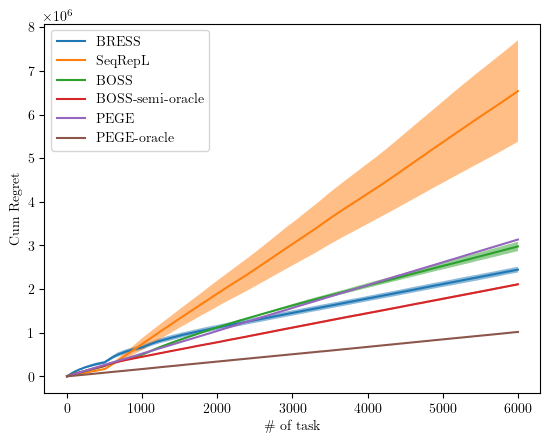

In [18]:
if run_experiments:
    mean_PEGE2 = np.mean(best_PEGE2["regrets"], axis=0)
    std_PEGE2 = np.std(best_PEGE2["regrets"], axis=0)
    mean_PEGE_oracle2 = np.mean(best_PEGE_oracle2["regrets"], axis=0)
    std_PEGE_oracle2 = np.std(best_PEGE_oracle2["regrets"], axis=0)
    mean_PMA2 = np.mean(best_PMA2["regrets"], axis=0)
    std_PMA2 = np.std(best_PMA2["regrets"], axis=0)
    mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2["regrets"], axis=0)
    std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2["regrets"], axis=0)
    mean_SeqRepL2 = np.mean(best_SeqRepL2["regrets"], axis=0)
    std_SeqRepL2 = np.std(best_SeqRepL2["regrets"], axis=0)
    mean_BRESS2 = np.mean(best_BRESS2["regrets"], axis=0)
    std_BRESS2 = np.std(best_BRESS2["regrets"], axis=0)
else:
    (
        mean_PEGE2,
        std_PEGE2,
        mean_PEGE_oracle2,
        std_PEGE_oracle2,
        mean_PMA2,
        std_PMA2,
        mean_PMA_no_oracle2,
        std_PMA_no_oracle2,
        mean_SeqRepL2,
        std_SeqRepL2,
    ) = load_dict("cache_data/NoTaskDiv_RegExp.npy")
    mean_BRESS2, std_BRESS2 = None, None

X = np.arange(1, n_task + 1)
if mean_BRESS2 is not None:
    plt.plot(X, mean_BRESS2, "-", label="BRESS")
    plt.fill_between(X, mean_BRESS2 - std_BRESS2, mean_BRESS2 + std_BRESS2, alpha=0.5)
plt.plot(X, mean_SeqRepL2, "-", label="SeqRepL")
plt.fill_between(
    X, mean_SeqRepL2 - std_SeqRepL2, mean_SeqRepL2 + std_SeqRepL2, alpha=0.5
)
plt.plot(X, mean_PMA_no_oracle2, "-", label="BOSS")
plt.fill_between(
    X,
    mean_PMA_no_oracle2 - std_PMA_no_oracle2,
    mean_PMA_no_oracle2 + std_PMA_no_oracle2,
    alpha=0.5,
)
plt.plot(X, mean_PMA2, "-", label="BOSS-semi-oracle")
plt.fill_between(X, mean_PMA2 - std_PMA2, mean_PMA2 + std_PMA2, alpha=0.5)
plt.plot(X, mean_PEGE2, "-", label="PEGE")
plt.fill_between(X, mean_PEGE2 - std_PEGE2, mean_PEGE2 + std_PEGE2, alpha=0.5)
plt.plot(X, mean_PEGE_oracle2, "-", label="PEGE-oracle")
plt.fill_between(
    X,
    mean_PEGE_oracle2 - std_PEGE_oracle2,
    mean_PEGE_oracle2 + std_PEGE_oracle2,
    alpha=0.5,
)
plt.xlabel(r"$\#$ of task")
plt.ylabel("Cum Regret")
plt.legend()
plt.show()
# plt.close()
# output_dict = {
#     "mean_PEGE2":mean_PEGE2,
#     "std_PEGE2":std_PEGE2,
#     "mean_PEGE_oracle2":mean_PEGE_oracle2,
#     "std_PEGE_oracle2":std_PEGE_oracle2,
#     "mean_PMA2":mean_PMA2,
#     "std_PMA2":std_PMA2,
#     # "mean_PMA_stop_exr2":mean_PMA_stop_exr2,
#     # "std_PMA_stop_exr2":std_PMA_stop_exr2,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle2,
#     "std_PMA_no_oracle2":std_PMA_no_oracle2,
#     "mean_SeqRepL2":mean_SeqRepL2,
#     "std_SeqRepL2":std_SeqRepL2,
# }
# np.save('cache_data/NoTaskDiv_RegExp.npy', output_dict)

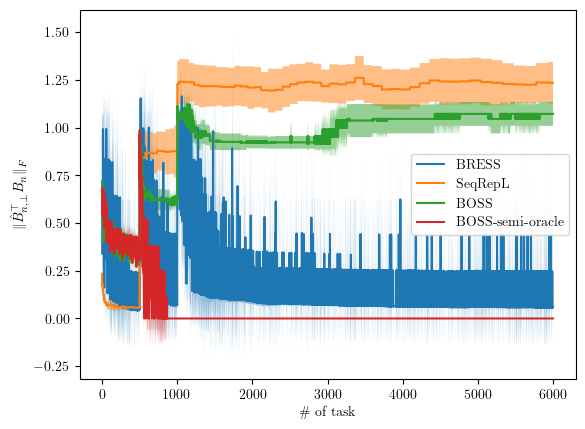

In [19]:
if run_experiments:
    mean_PMA2 = np.mean(best_PMA2["B_hat_err"], axis=0)
    std_PMA2 = np.std(best_PMA2["B_hat_err"], axis=0)
    mean_SeqRepL2 = np.mean(best_SeqRepL2["B_hat_err"], axis=0)
    std_SeqRepL2 = np.std(best_SeqRepL2["B_hat_err"], axis=0)
    mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2["B_hat_err"], axis=0)
    std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2["B_hat_err"], axis=0)
    mean_BRESS2 = np.mean(best_BRESS2["B_hat_err"], axis=0)
    std_BRESS2 = np.std(best_BRESS2["B_hat_err"], axis=0)
else:
    (
        mean_PEGE2,
        std_PEGE2,
        mean_PEGE_oracle2,
        std_PEGE_oracle2,
        mean_PMA2,
        std_PMA2,
        mean_PMA_no_oracle2,
        std_PMA_no_oracle2,
        mean_SeqRepL2,
        std_SeqRepL2,
    ) = load_dict("cache_data/NoTaskDiv_B.npy")
    mean_BRESS2, std_BRESS2 = None, None

X = np.arange(1, n_task + 1)
if mean_BRESS2 is not None:
    plt.plot(X, mean_BRESS2, "-", label="BRESS")
    plt.fill_between(X, mean_BRESS2 - std_BRESS2, mean_BRESS2 + std_BRESS2, alpha=0.5)
plt.plot(X, mean_SeqRepL2, "-", label="SeqRepL")
plt.fill_between(
    X, mean_SeqRepL2 - std_SeqRepL2, mean_SeqRepL2 + std_SeqRepL2, alpha=0.5
)
plt.plot(X, mean_PMA_no_oracle2, "-", label="BOSS")
plt.fill_between(
    X,
    mean_PMA_no_oracle2 - std_PMA_no_oracle2,
    mean_PMA_no_oracle2 + std_PMA_no_oracle2,
    alpha=0.5,
)
plt.plot(X, mean_PMA2, "-", label="BOSS-semi-oracle")
plt.fill_between(X, mean_PMA2 - std_PMA2, mean_PMA2 + std_PMA2, alpha=0.5)
plt.xlabel(r"$\#$ of task")
plt.ylabel(r"$\|\hat{B}_{n, \perp}^{\top} B_n\|_F$")
plt.legend()
plt.show()
# plt.close()
# output_dict = {
#     "mean_PMA2":mean_PMA2,
#     "std_PMA2":std_PMA2,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle2,
#     "std_PMA_no_oracle2":std_PMA_no_oracle2,
#     "mean_SeqRepL2":mean_SeqRepL2,
#     "std_SeqRepL2":std_SeqRepL2,
# }
# np.save('cache_data/NoTaskDiv_B.npy', output_dict)

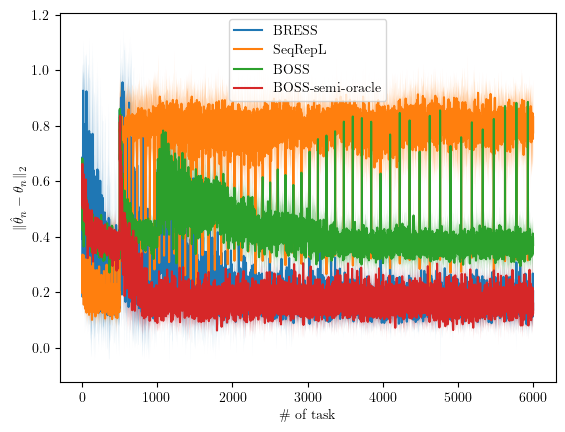

In [20]:
if run_experiments:
    mean_PMA2 = np.mean(best_PMA2["theta_hat_err"], axis=0)
    std_PMA2 = np.std(best_PMA2["theta_hat_err"], axis=0)
    mean_SeqRepL2 = np.mean(best_SeqRepL2["theta_hat_err"], axis=0)
    std_SeqRepL2 = np.std(best_SeqRepL2["theta_hat_err"], axis=0)
    mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2["theta_hat_err"], axis=0)
    std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2["theta_hat_err"], axis=0)
    mean_BRESS2 = np.mean(best_BRESS2["theta_hat_err"], axis=0)
    std_BRESS2 = np.std(best_BRESS2["theta_hat_err"], axis=0)
else:
    (
        mean_PEGE2,
        std_PEGE2,
        mean_PEGE_oracle2,
        std_PEGE_oracle2,
        mean_PMA2,
        std_PMA2,
        mean_PMA_no_oracle2,
        std_PMA_no_oracle2,
        mean_SeqRepL2,
        std_SeqRepL2,
    ) = load_dict("cache_data/NoTaskDiv_theta.npy")
    mean_BRESS2, std_BRESS2 = None, None

X = np.arange(1, n_task + 1)
if mean_BRESS2 is not None:
    plt.plot(X, mean_BRESS2, "-", label="BRESS")
    plt.fill_between(X, mean_BRESS2 - std_BRESS2, mean_BRESS2 + std_BRESS2, alpha=0.5)
plt.plot(X, mean_SeqRepL2, "-", label="SeqRepL")
plt.fill_between(
    X, mean_SeqRepL2 - std_SeqRepL2, mean_SeqRepL2 + std_SeqRepL2, alpha=0.5
)
plt.plot(X, mean_PMA_no_oracle2, "-", label="BOSS")
plt.fill_between(
    X,
    mean_PMA_no_oracle2 - std_PMA_no_oracle2,
    mean_PMA_no_oracle2 + std_PMA_no_oracle2,
    alpha=0.5,
)
plt.plot(X, mean_PMA2, "-", label="BOSS-semi-oracle")
plt.fill_between(X, mean_PMA2 - std_PMA2, mean_PMA2 + std_PMA2, alpha=0.5)
plt.xlabel(r"$\#$ of task")
plt.ylabel(r"$\|\hat{\theta}_n - \theta_n\|_2$")
plt.legend()
plt.show()
# plt.close()
# output_dict = {
#     "mean_PMA2":mean_PMA2,
#     "std_PMA2":std_PMA2,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle2,
#     "std_PMA_no_oracle2":std_PMA_no_oracle2,
#     "mean_SeqRepL2":mean_SeqRepL2,
#     "std_SeqRepL2":std_SeqRepL2,
# }
# np.save('cache_data/NoTaskDiv_theta.npy', output_dict)

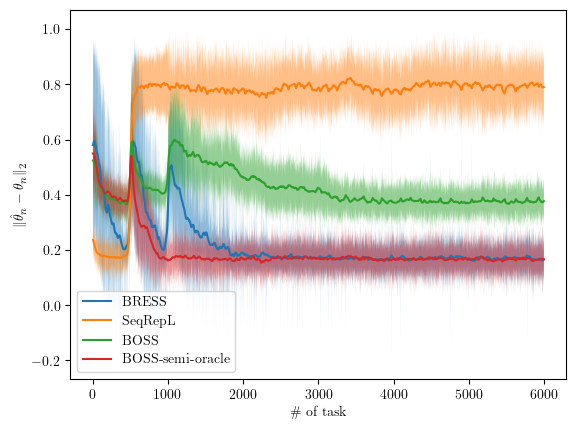

In [21]:
rbf = Rbf(X, mean_PMA_no_oracle2, function="multiquadric", smooth=500)
y_PMA_no_oracle_rbf2 = rbf(X)
rbf = Rbf(X, mean_PMA2, function="multiquadric", smooth=500)
y_PMA_rbf2 = rbf(X)
rbf = Rbf(X, mean_SeqRepL2, function="multiquadric", smooth=500)
y_SeqRepL_rbf2 = rbf(X)
if mean_BRESS2 is not None:
    rbf = Rbf(X, mean_BRESS2, function="multiquadric", smooth=500)
    y_BRESS_rbf2 = rbf(X)

if mean_BRESS2 is not None:
    plt.plot(X, y_BRESS_rbf2, "-", label="BRESS")
    plt.fill_between(X, y_BRESS_rbf2 - std_BRESS2, y_BRESS_rbf2 + std_BRESS2, alpha=0.5)
plt.plot(X, y_SeqRepL_rbf2, "-", label="SeqRepL")
plt.fill_between(
    X, y_SeqRepL_rbf2 - std_SeqRepL2, y_SeqRepL_rbf2 + std_SeqRepL2, alpha=0.5
)
plt.plot(X, y_PMA_no_oracle_rbf2, "-", label="BOSS")
plt.fill_between(
    X,
    y_PMA_no_oracle_rbf2 - std_PMA_no_oracle2,
    y_PMA_no_oracle_rbf2 + std_PMA_no_oracle2,
    alpha=0.5,
)
plt.plot(X, y_PMA_rbf2, "-", label="BOSS-semi-oracle")
plt.fill_between(X, y_PMA_rbf2 - std_PMA2, y_PMA_rbf2 + std_PMA2, alpha=0.5)
plt.xlabel(r"$\#$ of task")
plt.ylabel(r"$\|\hat{\theta}_n - \theta_n\|_2$")

plt.legend()
plt.show()

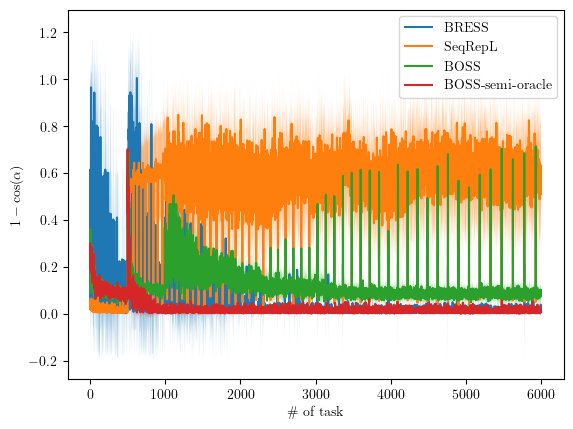

In [22]:
if run_experiments:
    mean_PMA2 = np.mean(best_PMA2["angle_err"], axis=0)
    std_PMA2 = np.std(best_PMA2["angle_err"], axis=0)
    mean_SeqRepL2 = np.mean(best_SeqRepL2["angle_err"], axis=0)
    std_SeqRepL2 = np.std(best_SeqRepL2["angle_err"], axis=0)
    mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2["angle_err"], axis=0)
    std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2["angle_err"], axis=0)
    mean_BRESS2 = np.mean(best_BRESS2["angle_err"], axis=0)
    std_BRESS2 = np.std(best_BRESS2["angle_err"], axis=0)
else:
    (
        mean_PEGE2,
        std_PEGE2,
        mean_PEGE_oracle2,
        std_PEGE_oracle2,
        mean_PMA2,
        std_PMA2,
        mean_PMA_no_oracle2,
        std_PMA_no_oracle2,
        mean_SeqRepL2,
        std_SeqRepL2,
    ) = load_dict("cache_data/NoTaskDiv_angle.npy")
    mean_BRESS2, std_BRESS2 = None, None

X = np.arange(1, n_task + 1)
if mean_BRESS2 is not None:
    plt.plot(X, mean_BRESS2, "-", label="BRESS")
    plt.fill_between(X, mean_BRESS2 - std_BRESS2, mean_BRESS2 + std_BRESS2, alpha=0.5)
plt.plot(X, mean_SeqRepL2, "-", label="SeqRepL")
plt.fill_between(
    X, mean_SeqRepL2 - std_SeqRepL2, mean_SeqRepL2 + std_SeqRepL2, alpha=0.5
)
plt.plot(X, mean_PMA_no_oracle2, "-", label="BOSS")
plt.fill_between(
    X,
    mean_PMA_no_oracle2 - std_PMA_no_oracle2,
    mean_PMA_no_oracle2 + std_PMA_no_oracle2,
    alpha=0.5,
)
plt.plot(X, mean_PMA2, "-", label="BOSS-semi-oracle")
plt.fill_between(X, mean_PMA2 - std_PMA2, mean_PMA2 + std_PMA2, alpha=0.5)
plt.xlabel(r"$\#$ of task")
plt.ylabel(r"$1-\cos(\alpha)$")
plt.legend()
plt.show()
# plt.close()
# output_dict = {
#     "mean_PMA2":mean_PMA2,
#     "std_PMA2":std_PMA2,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle2,
#     "std_PMA_no_oracle2":std_PMA_no_oracle2,
#     "mean_SeqRepL2":mean_SeqRepL2,
#     "std_SeqRepL2":std_SeqRepL2,
# }
# np.save('cache_data/NoTaskDiv_angle.npy', output_dict)

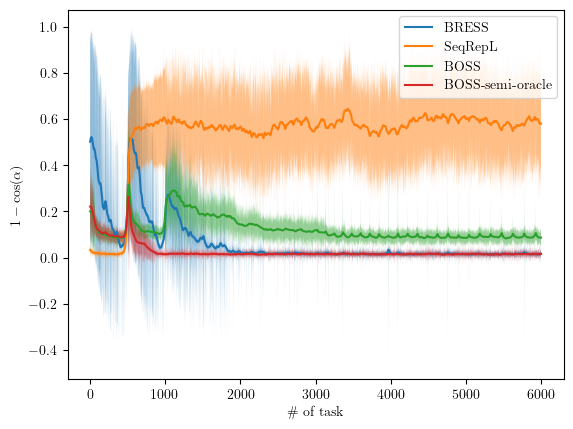

In [23]:
rbf = Rbf(X, mean_PMA_no_oracle2, function="multiquadric", smooth=500)
y_PMA_no_oracle_rbf2 = rbf(X)
rbf = Rbf(X, mean_PMA2, function="multiquadric", smooth=500)
y_PMA_rbf2 = rbf(X)
rbf = Rbf(X, mean_SeqRepL2, function="multiquadric", smooth=500)
y_SeqRepL_rbf2 = rbf(X)
if mean_BRESS2 is not None:
    rbf = Rbf(X, mean_BRESS2, function="multiquadric", smooth=500)
    y_BRESS_rbf2 = rbf(X)

if mean_BRESS2 is not None:
    plt.plot(X, y_BRESS_rbf2, "-", label="BRESS")
    plt.fill_between(X, y_BRESS_rbf2 - std_BRESS2, y_BRESS_rbf2 + std_BRESS2, alpha=0.5)
plt.plot(X, y_SeqRepL_rbf2, "-", label="SeqRepL")
plt.fill_between(
    X, y_SeqRepL_rbf2 - std_SeqRepL2, y_SeqRepL_rbf2 + std_SeqRepL2, alpha=0.5
)
plt.plot(X, y_PMA_no_oracle_rbf2, "-", label="BOSS")
plt.fill_between(
    X,
    y_PMA_no_oracle_rbf2 - std_PMA_no_oracle2,
    y_PMA_no_oracle_rbf2 + std_PMA_no_oracle2,
    alpha=0.5,
)
plt.plot(X, y_PMA_rbf2, "-", label="BOSS-semi-oracle")
plt.fill_between(X, y_PMA_rbf2 - std_PMA2, y_PMA_rbf2 + std_PMA2, alpha=0.5)
plt.xlabel(r"$\#$ of task")
plt.ylabel(r"$1-\cos(\alpha)$")

plt.legend()
plt.show()

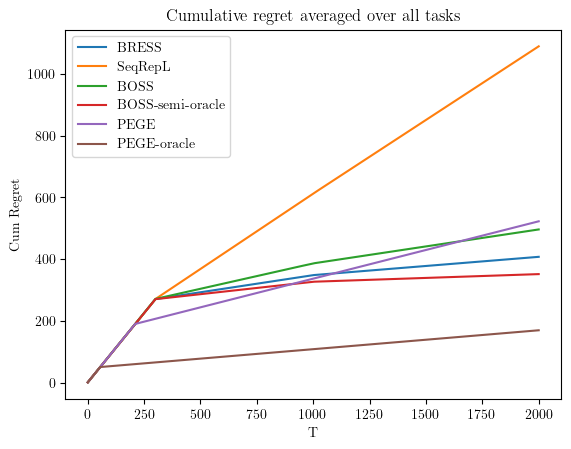

In [24]:
if run_experiments:
    mean_PEGE2_in_T = np.mean(best_PEGE2["regrets_all"], axis=(0, -1))
    std_PEGE2_in_T = np.std(best_PEGE2["regrets_all"], axis=(0, -1))
    mean_PEGE_oracle2_in_T = np.mean(best_PEGE_oracle2["regrets_all"], axis=(0, -1))
    std_PEGE_oracle2_in_T = np.std(best_PEGE_oracle2["regrets_all"], axis=(0, -1))
    mean_PMA2_in_T = np.mean(best_PMA2["regrets_all"], axis=(0, -1))
    std_PMA2_in_T = np.std(best_PMA2["regrets_all"], axis=(0, -1))
    mean_PMA_no_oracle2_in_T = np.mean(best_PMA_no_oracle2["regrets_all"], axis=(0, -1))
    std_PMA_no_oracle2_in_T = np.std(best_PMA_no_oracle2["regrets_all"], axis=(0, -1))
    mean_SeqRepL2_in_T = np.mean(best_SeqRepL2["regrets_all"], axis=(0, -1))
    std_SeqRepL2_in_T = np.std(best_SeqRepL2["regrets_all"], axis=(0, -1))
    mean_BRESS2_in_T = np.mean(best_BRESS2["regrets_all"], axis=(0, -1))
    std_BRESS2_in_T = np.std(best_BRESS2["regrets_all"], axis=(0, -1))
else:
    (
        mean_PEGE2_in_T,
        std_PEGE2_in_T,
        mean_PEGE_oracle2_in_T,
        std_PEGE_oracle2_in_T,
        mean_PMA2_in_T,
        std_PMA2_in_T,
        mean_PMA_no_oracle2_in_T,
        std_PMA_no_oracle2_in_T,
        mean_SeqRepL2_in_T,
        std_SeqRepL2_in_T,
    ) = load_dict("cache_data/NoTaskDiv_T.npy")
    mean_BRESS2_in_T = None

X = np.arange(1, T + 1)
if mean_BRESS2_in_T is not None:
    plt.plot(X, mean_BRESS2_in_T, "-", label="BRESS")
plt.plot(X, mean_SeqRepL2_in_T, "-", label="SeqRepL")
plt.plot(X, mean_PMA_no_oracle2_in_T, "-", label="BOSS")
plt.plot(X, mean_PMA2_in_T, "-", label="BOSS-semi-oracle")
plt.plot(X, mean_PEGE2_in_T, "-", label="PEGE")
plt.plot(X, mean_PEGE_oracle2_in_T, "-", label="PEGE-oracle")
plt.xlabel("T")
plt.ylabel("Cum Regret")
plt.legend()
plt.title(f"Cumulative regret averaged over all tasks")
plt.show()
# plt.close()
# output_dict = {
#     "mean_PEGE2":mean_PEGE2_in_T,
#     "std_PEGE2":std_PEGE2_in_T,
#     "mean_PEGE_oracle2":mean_PEGE_oracle2_in_T,
#     "std_PEGE_oracle2":std_PEGE_oracle2_in_T,
#     "mean_PMA2":mean_PMA2_in_T,
#     "std_PMA2":std_PMA2_in_T,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle2_in_T,
#     "std_PMA_no_oracle2":std_PMA_no_oracle2_in_T,
#     "mean_SeqRepL2":mean_SeqRepL2_in_T,
#     "std_SeqRepL2":std_SeqRepL2_in_T,
# }
# np.save('cache_data/NoTaskDiv_T.npy', output_dict)